# Uplift

Банк запускает активационные кампании по кредитным картам с использованием различных каналов коммуникации. Персональные звонки клиентам - довольно затратный способ коммуникации, при этом не все клиенты позитивно реагируют на такой формат общения: кому-то будет достаточно СМС или пуш-уведомления.
Ваша задача — помочь банку оптимизировать расходы на коммуникации, научившись предсказывать разницу в эффективности голосовых звонков на основе клиентских данных. В качестве решения необходимо предоставить предсказанный моделью uplift для каждого клиента из тестовой выборки.

Данные:

Используя историю взаимодействий, сессии мобильного приложения, заявки на продукты и другие признаки, вам предстоит создать модель, которая сможет повысить эффективность кампаний за счет персонализированного выбора наиболее подходящего способа общения с каждым клиентом.

Признаки, которые содержатся в выборках:
* successful_utilization – переменная, которая показывает, воспользовался ли клиент кредитным продуктом

* retro_date – дата создания задачи на клиента

* treatment – колонка, которая показывает, имела ли место голосовая коммуникация с клиентом. 1 – с клиентом общались по голосовому каналу, 0 – с клиентом в этот момент могли общаться по голосовому каналу, но не стали

* mb – группа признаков, которая характеризует сессии в мобильном приложении клиента

* application – группа признаков, которая характеризует различные заявки клиентов на наши продукты в прошлом

* bki - группа признаков, которая характеризует походы клиентов в Бюро Кредитных Историй

* partner - группа признаков, которая характеризует различные подписки клиентов на партнерские сервисы

* graph - группа признаков, которая характеризует данные о контактных книжках наших клиентов

* feature – группа признаков, которая скрыта от описания

Метрика:
Качество решения определяется с помощью метрики Area under uplift curve (AUUQ).

Подробнее про метрику - https://habr.com/ru/companies/ru_mts/articles/538934/

# Решение

In [ ]:
!pip install scikit-uplift

In [ ]:
!pip install catboost -q

In [ ]:
!pip install causalml -q

In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer

from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder

# from causalml.inference.tree import UpliftTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn import metrics
import matplotlib.pyplot as plt

np.random.seed(0)

import seaborn as sns

from sklift.metrics import qini_auc_score, uplift_auc_score
from sklift.viz import plot_qini_curve

In [ ]:
# load train and test data

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

<ipython-input-31-04692d7958e9>:3: DtypeWarning: Columns (142) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train-4.csv")


,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date,successful_utilization,treatment
0,NaN,1.0,Representatives,123.0,Первичная ДК,1,14.0,147000.0,PLT,0.0,...,NaN,0.0,1.0,0.0,-1.2,1.0,0.0,2024-07-04,0.0,1.0
1,NaN,1.0,Offline,43.0,Airports,0,1.0,120000.0,PLT,0.0,...,1.0,0.0,1.0,0.0,-1.2,1.0,0.0,2024-06-06,0.0,1.0
2,0.0,1.0,Web,2.0,seo,0,NaN,15000.0,PLT,0.0,...,NaN,0.0,NaN,0.0,-1.2,1.0,0.0,2024-07-21,1.0,1.0
3,0.0,1.0,MB,2.0,One Click Offer,0,91.0,260000.0,PLT,0.0,...,1.0,0.0,NaN,1.0,-1.2,1.0,0.0,2024-05-23,0.0,1.0
4,0.0,1.0,Representatives,123.0,Первичная ДК,1,1.0,130000.0,PLT,0.0,...,NaN,0.0,1.0,0.0,-1.2,1.0,0.0,2024-06-28,0.0,1.0


In [ ]:
test.head()

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,bki_46,feature_24,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date
0,0.0,1.0,NaN,NaN,NaN,0,6.0,NaN,NaN,0.0,...,373942.0,0.0,1.0,0,0.0,0.0,-1.2,1.0,0,2024-06-18
1,0.0,1.0,NaN,NaN,NaN,0,45.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0,0.0,1.0,-1.2,1.0,0,2024-05-09
2,0.0,1.0,MB,2.0,Heavy xsell,0,13.0,299000.0,PLT,0.0,...,9724333.0,NaN,NaN,0,NaN,0.0,-1.2,1.0,0,2024-05-30
3,0.0,1.0,Representatives,123.0,SIM,1,158.0,140000.0,PLT,0.0,...,0.0,0.0,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-27
4,0.0,1.0,Representatives,123.0,Первичная ДК,0,36.0,170000.0,PLT,0.0,...,2237284.0,0.0,0.0,0,1.0,0.0,-1.2,1.0,0,2024-06-08


Обрабатываем признаки

In [ ]:
feature_cols = [c for c in list(train.columns) if c != "successful_utilization" and c != "treatment"]
X_train = train[feature_cols]
X_test = test[feature_cols]

y_train = train["successful_utilization"]
treatment_train = train['treatment']

In [ ]:
categorical_features = X_train.select_dtypes(exclude='number').columns
numeric_features = X_train.select_dtypes(include='number').columns

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop='first')),
    ]
)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", imp, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

ppl = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

In [ ]:
ppl.fit(X_train)
X_train = ppl.transform(X_train)
X_test = ppl.transform(X_test)

Обучаем модель

Как работает ClassTransformation:

1. Цель метода:

ClassTransformation преобразует исходную задачу uplift-моделирования в задачу классификации. Цель состоит в том, чтобы создать модель, которая будет предсказывать вероятность целевого события с учётом проведенного воздействия (например, воздействия на целевую группу) и без него (на контрольную группу).

2. Преобразование задачи:

Этот метод изменяет целевую переменную и признаки таким образом, чтобы можно было обучать обычную модель классификации (например, логистическую регрессию или случайный лес) для предсказания uplift-эффекта:

Для каждого объекта создается две копии, одна из которых относится к контрольной группе (без воздействия), а другая — к группе с воздействием.

Создается новая переменная, которая определяется как разница между вероятностью положительного исхода в группе с воздействием и контрольной группой.

3. Алгоритм работы:

Вот шаги, которые происходят в ClassTransformation:

Для каждого объекта из контрольной и целевой группы дублируются данные с новым бинарным признаком treatment, который принимает значение:

1, если объект находится в целевой группе (объект получил интервенцию),
0, если объект в контрольной группе (интервенции нет).
Для группы с воздействием и без него создаются дублированные объекты с новой целевой переменной, которая для объекта в целевой группе равна целевой переменной, а для объекта в "контрольной" — это "искусственно" созданная противоположная цель. Это помогает модели научиться различать разницу в вероятности целевого события для обеих групп.

Модель классификации обучается на этих дублированных данных.

После обучения предсказания модели можно интерпретировать как uplift-эффект (разница в вероятности целевого события в зависимости от воздействия).



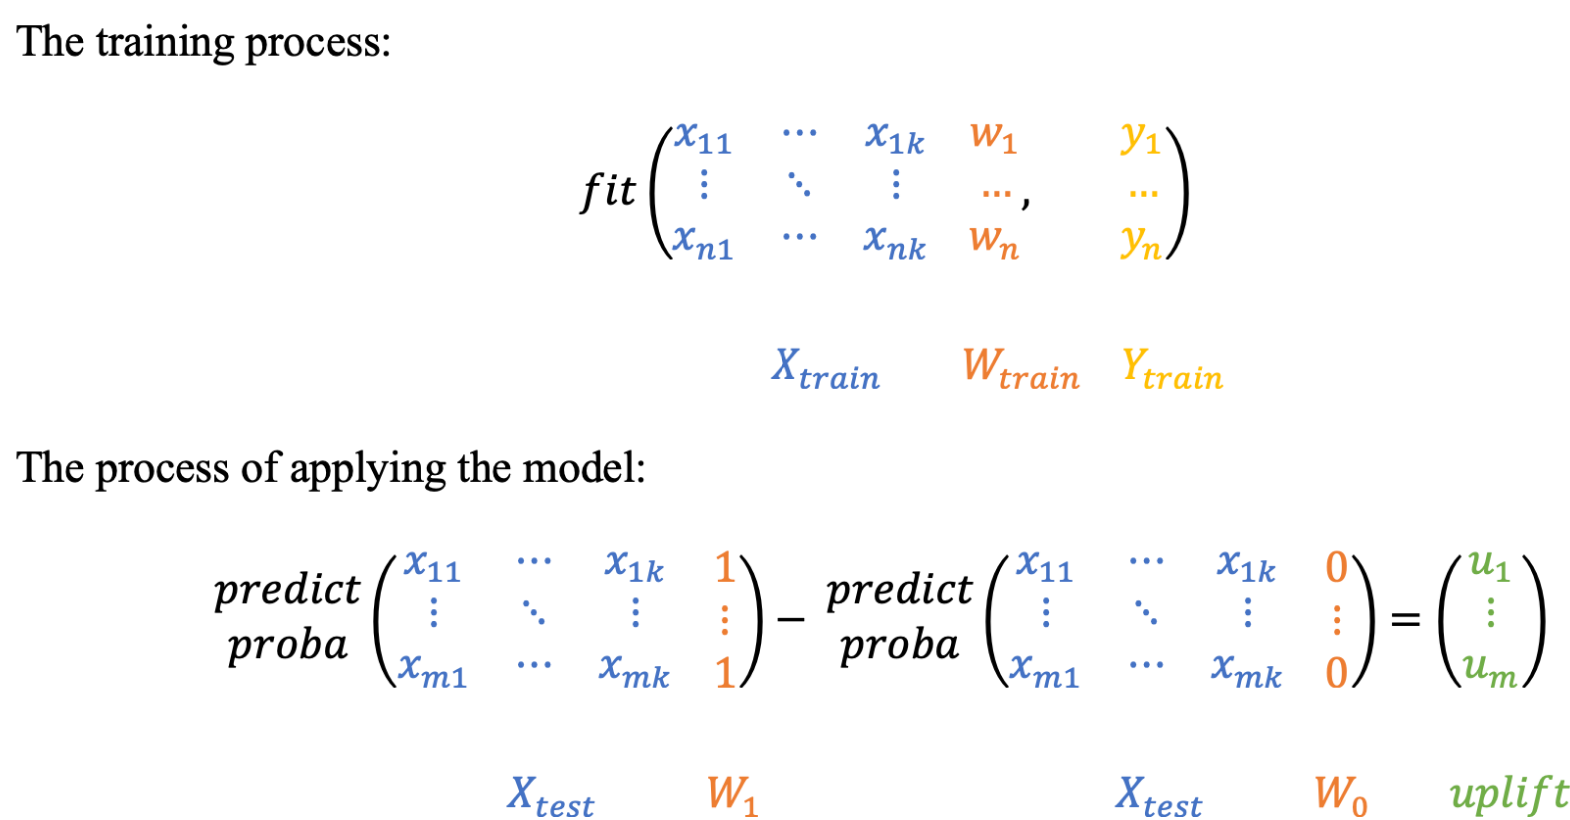

In [ ]:
estimator = CatBoostClassifier(verbose=100,
                               random_state=42,
                               thread_count=1)

ct_model = ClassTransformation(estimator=estimator)

In [ ]:
ct_model.fit(
    X=X_train,
    y=y_train,
    treatment=treatment_train
)

In [ ]:
uplift_ct = ct_model.predict(X_test)

In [ ]:
pd.DataFrame(uplift_ct).to_csv("submission_prob.csv", header=False)
pd.DataFrame(uplift_ct > 0).to_csv("submission.csv", header=False)

In [ ]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_ct, treatment_test)
print(f"Qini coefficient on full data: {auqc:.4f}")
auuc = uplift_auc_score(y_test, uplift_ct, treatment_test)
print(f"AUUC coefficient on full data: {auuc:.4f}")

Qini coefficient on full data: 0.0736
AUUC coefficient on full data: 0.0700


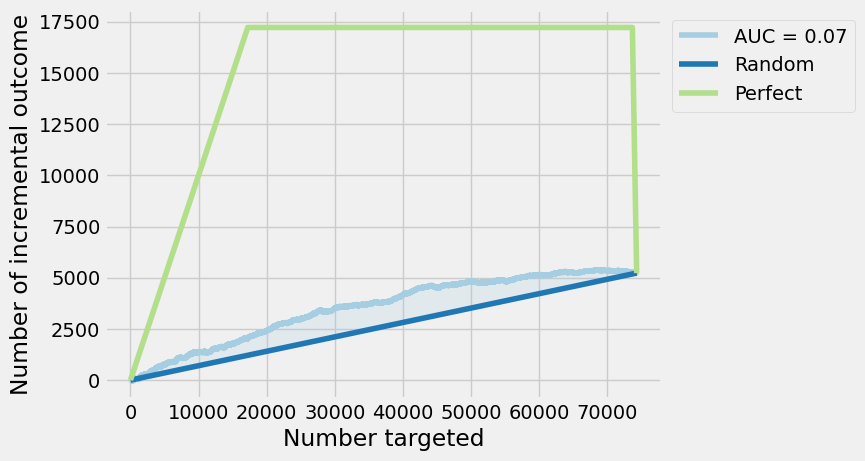

In [ ]:
# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_test, uplift_ct, treatment_test, perfect=True)

### Как можно улучшить прогноз?

* Работа с признаками

* Подбор гиперпараметров

* Metalearners. Методы основанные на использовании моделей машинного обучения в качестве базовых

* Преобразование классов

* Uplift-решающие деревья и методы, основанные на их ансамблях